# Session 2: General linear model

In this session, we will learn how to make a design matrix with different regressors and get the statistical maps.


## Tools We’ll Use

### **Nilearn**
We will use **[Nilearn](https://nilearn.github.io/stable/index.html)** — a comprehensive neuroimaging python package focused specifically on modeling fMRI data (so it does not have too much functionality with preprocessing).

Nilearn enables approachable and versatile analyses of brain volumes and surfaces. It provides statistical and machine-learning tools, with instructive documentation & open community.

It supports general linear model (GLM) based analysis and leverages the scikit-learn Python toolbox for multivariate statistics with applications such as predictive modeling, classification, decoding, or connectivity analysis.

Please run the cell below for the runtime of each notebook. It will import necessary packages that you require to go through this tutorial.

In [ ]:
# --- Basic Setup (always run this first) ---

# Install dependencies 
%pip install -q gdown
%pip install -q git+https://github.com/Yuan-fang/fMRI-tutorial.git

# Import essential packages
import warnings
from pathlib import Path
import shutil
#import module
from nilearn import image, plotting
from nilearn.image import index_img
from nilearn.glm.first_level import glover_hrf, spm_hrf, compute_regressor, FirstLevelModel
from bids import BIDSLayout
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from tutorial.utils.paths import PathManager

warnings.filterwarnings("ignore")


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


We also need to set up data directories. You can change to other directories and names according to your preference for your own project. But for this tutorial, let's stick with the same data directories.

In [110]:
# --- Set up data directories ---

DATASET = "Haxby2001" # name of the dataset
BASE_DIR = Path("..")    # base directory for the tutorial
DATA_DIR = BASE_DIR / "data" / DATASET # data directory for the dataset
DERIV_DIR = BASE_DIR / "data" / "derivatives" # derivatives directory for processed data

for p in (DATA_DIR, DERIV_DIR):
    p.mkdir(parents=True, exist_ok=True)

# Print out the data directories
print("Data directory:       ", DATA_DIR.resolve())
print("Derivatives directory:", DERIV_DIR.resolve())

Data directory:        /Users/yuanfangzhao/Documents/Teaching/Neuroimaging/fMRI_colab_tutorial/data/Haxby2001
Derivatives directory: /Users/yuanfangzhao/Documents/Teaching/Neuroimaging/fMRI_colab_tutorial/data/derivatives


In [ ]:
# --- Download this session's dataset ---

# Google Drive link to the dataset
download_url = "https://drive.google.com/uc?id=1fPjbWhY6ZDOGSm59duKmOcCpgp5Zf5tX"
fetch_dataset(download_url, DERIV_DIR)

In [111]:
# Create a BIDSLayout object to interface with the BIDS dataset
layout = BIDSLayout(DATA_DIR, validate=False)  
print(f"BIDS dataset with {len(layout.get_subjects())} subjects loaded.")

BIDS dataset with 6 subjects loaded.


In [112]:
# Get the file path of run 1's functional image for a specific subject ("sub-1")
func_path = layout.get(subject="1", suffix="bold", extension=".nii.gz", run="1", return_type="file")[0]
print("Functional files for subject 1, run 1:", func_path)

Functional files for subject 1, run 1: /Users/yuanfangzhao/Documents/Teaching/Neuroimaging/fMRI_colab_tutorial/notebooks/../data/Haxby2001/sub-1/func/sub-1_task-objectviewing_run-01_bold.nii.gz


In [113]:
# Create a PathManager object 'fsl_manager', which is specifically for managing file paths related to FSL processing.
fsl_manager = PathManager(
    BIDSlayout=layout,
    deriv_base=DERIV_DIR,
    pipeline="fsl_preproc"
    )

### GLM on a single run

Let's first get the file paths of the data we need for GLM analysis.

In [114]:
# Get the file path of the preprocessed functional image for subject "sub-1", run "1"
func_r1_path = fsl_manager.find_path(subject="1", run="1", proc="clean", extension=".nii.gz")[0]
print("Preprocessed functional files for subject 1, run 1:", func_r1_path)

# Get the event timing file for subject "sub-1", run "1"
event_r1_file = layout.get(subject="1", suffix="events", extension=".tsv", run="1", return_type="file")[0]
print("Event timing file for subject 1, run 1:", event_r1_file)

Preprocessed functional files for subject 1, run 1: /Users/yuanfangzhao/Documents/Teaching/Neuroimaging/fMRI_colab_tutorial/data/derivatives/fsl_preproc/sub-1/func/sub-1_task-objectviewing_run-01_proc-clean_bold_MNI.nii.gz
Event timing file for subject 1, run 1: /Users/yuanfangzhao/Documents/Teaching/Neuroimaging/fMRI_colab_tutorial/notebooks/../data/Haxby2001/sub-1/func/sub-1_task-objectviewing_run-01_events.tsv


We can load the information from the event timing file and look what's inside.

In [115]:
# Load the event timing file into a pandas DataFrame
events_r1 = pd.read_csv(event_r1_file, sep="\t")
# Display the first 20 rows of the events DataFrame
# Note that the unit of 'onset' and 'duration' is in seconds
events_r1.head(20)

,onset,duration,trial_type
0,12.0,0.5,scissors
1,14.0,0.5,scissors
2,16.0,0.5,scissors
3,18.0,0.5,scissors
4,20.0,0.5,scissors
5,22.0,0.5,scissors
6,24.0,0.5,scissors
7,26.0,0.5,scissors
8,28.0,0.5,scissors
9,30.0,0.5,scissors


After loading the event timing information, we can visualize them.

In [ ]:
fig = plotting.plot_event(events_r1)

#### 🤔 Do it yourself: 
Please load the event timing information of run 2 of this subject, and visualize its event timing information.

_Type your answer in the cell below. then check the answer._

<details>
<summary>💡 Show the correct answer</summary>

````python
# Get the event timing file for subject "sub-1", run "2"
event_r2_file = layout.get(subject="1", suffix="events", extension=".tsv", run="2", return_type="file")[0]

# Load the event timing file into a pandas DataFrame
events_r2 = pd.read_csv(event_r2_file, sep="\t")


# Visualize the event timing information of run 2 of this subject
fig = plotting.plot_event(events_r2)

````
</details>


In [ ]:
# Write and execute your code below to visualize the event timing information of run 2 of this subject.
# --- YOUR CODE HERE ---



### HRF models and HRF-convolved regressor (predictor)

Hemodynamic response function (HRF) is a curve that shows how the fMRI signal rises and falls over time after a brief burst of brain activity (or equivalently, a single impulse event). 

There are many different HRF models in Nilearn. Two most common HRF models are:
1. Glover HRF, which is a HRF model based on the double-gamma function proposed by Glover (1999). 
2. SPM HRF, which is another commonly used HRF model based on the canonical HRF used in SPM software.

In [ ]:
# Here we generate the Glover HRF using nilearn's glover_hrf function.
# time resolution (TR) = 1s, time length is the length of the HRF to be generated (32s here), onset=0s
hrf_glover = glover_hrf(t_r=1, oversampling=1,time_length=32, onset=0)

# Plot the glover HRF
plt.figure(figsize=(8, 4)) # Set the figure size
plt.plot(hrf_glover, label='Glover HRF', color='blue')
plt.title('Glover Hemodynamic Response Function (HRF)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [ ]:
# Compare the Glover HRF with the SPM HRF
hrf_spm = spm_hrf(t_r=1, oversampling=1, time_length=32, onset=0)

# Plot both HRFs for comparison
plt.figure(figsize=(8, 4)) # Set the figure size
plt.plot(hrf_glover, label='Glover HRF', color='blue')   
plt.plot(hrf_spm, label='SPM HRF', color='orange')
plt.title('Comparison of Glover and SPM Hemodynamic Response Functions (HRFs)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

What differences do you notice of these two models?  

Although with those differences, overall, Glover model is similiar to SPM model, and fortunately, using either model indeed does not make a huge difference if what you care is only activations. So we will stick with the Glover model from here onwards.

With the HRF model, what we will do next is to **convolve** the HRF to events with specific timings, so that we can get a predictor (regressor) of BOLD response from that event.

In [ ]:
# -------- Convolution with Glover HRF ------

# We need to first create a stimulus to convolve with the HRF
# for simplicity, we create an impulse stimulus (a delta function) at time 0, with duration of 1s
impulse = np.zeros(100)    # Create an array of zeros with length 100s
impulse[0] = 1             # Set the first element to 1 to represent an impulse at time 0 with intensity 1
# plot the impulse stimulus
plt.figure(figsize=(8, 4)) # Set the figure size
plt.stem(impulse, label='Impulse Stimulus')
plt.title('Impulse Stimulus')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [ ]:
# Convolve the impulse with the Glover HRF
convolved_response = np.convolve(impulse, hrf_glover)[:100]  # Keep only the first 100s of the convolved response
# Plot the convolved response
plt.figure(figsize=(10, 4)) # Set the figure size
plt.plot(convolved_response, label='Convolved Response', color='green')
plt.title('Convolved Response of Impulse with Glover HRF')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

You can try to adjust the duration of the stimulus by yourself, to see its effect on the convolved response. Here, we adjust the stimulus series to make it has more random pulse stimuli, and see what the predicted convolved response will look like.

In [ ]:
# still we have a volume of zeros with length 100s
impulse = np.zeros(100)    # Create an array of zeros with length 100s
# set 50 random impulses in the stimulus
random_times = np.random.choice(np.arange(100), size=50, replace=False)
impulse[random_times] = 1
# plot the impulse stimulus
plt.figure(figsize=(8, 4)) # Set the figure size
plt.stem(impulse, label='Impulse Stimulus')
plt.title('Impulse Stimulus')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [ ]:
# Convolve the impulse with the Glover HRF
convolved_response = np.convolve(impulse, hrf_glover)[:100]  # Keep only the first 100s of the convolved response
# Plot the convolved response
plt.figure(figsize=(10, 4)) # Set the figure size
plt.plot(convolved_response, label='Convolved Response', color='green')
plt.title('Convolved Response of Impulse with Glover HRF')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

The event timing file in each run contains the 'onset' and 'duration' information for each type of stimulus (conditions), which in essence gives us information about the timing of stimulus series. As one run always contains 2 or more than 2 conditions (sometimes > 8 conditions if in fast event-related designs), we just need to split the whole timing info into those for each condition and do the convolution seperately for each condition. Nicely, Nilearn provides us a convenient tool to do this: `compute_regressor`. 

In [ ]:
# get the events for a specific condition: 'house'
house_events = events_r1[events_r1['trial_type'] == 'house']
print(house_events)

In [ ]:
# Define time frame parameter
tr = 2.5  # repetition time in seconds
n_scans = 121 # number of scans in the functional run
frame_times = np.arange(n_scans) * tr  # frame times in seconds

# define the condition events for 'face' condition
condition_events = np.array([
    house_events['onset'].values,
    house_events['duration'].values,
    np.ones(len(house_events))  # amplitude is set to 1 for all events
])

# Now we can use the `compute_regressor` function from nilearn to generate the regressor for this condition
regressor, _ = compute_regressor(
    exp_condition=condition_events,
    frame_times=frame_times,
    hrf_model='glover',
    con_id='face'
)

# Plot the generated regressor
plt.figure(figsize=(10, 4)) # Set the figure size
plt.plot(regressor, label='Face Regressor', color='purple')
plt.title('Generated Regressor for House Condition using Glover HRF')
plt.xlabel('Time (s)')  
plt.ylabel('Amplitude')
plt.legend()
plt.show()

We've known that house images evoke responses in the parahippocampal place area (PPA). In MNI152 template space, MNI coordinates (27, -53, -8) is in PPA's range.

#### 🤔 Do it yourself: 
Please plot the fMRI timecourse from preprocessed run 1 at the voxel with MNI coordinates (27, -53, -8). 

_Type your answer in the cell below. then check the answer._

<details>
<summary>💡 Show the correct answer</summary>

````python
# Load the filtered functional image
filtered_func_img = image.load_img(func_r1_path)

# Load the filtered image data as a numpy array from the Nifti1Image object
filtered_func_data = filtered_func_img.get_fdata()

# invert the affine
inv_affine = np.linalg.inv(filtered_func_img.affine)

# apply the inverse transform: world -> voxel
i, j, k = image.coord_transform(27, -53, -8, inv_affine)

# convert to integer voxel indices for numpy indexing
voxel_idx = np.round([i, j, k]).astype(int)

# extract the time series at the specified voxel
time_series_filtered = filtered_func_data[tuple(voxel_idx)]

# Plot the time series
# We use matplotlib for plotting.
# see https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html for more options
plt.figure(figsize=(10, 4)) # Set the figure size
plt.plot(time_series_filtered, label="After Filtering")
plt.title("Voxel time course at (27, -53, -8) mm")
plt.xlabel("Time (TRs)")
plt.ylabel("Signal intensity")
plt.legend()
plt.show()

````
</details>


In [ ]:
# Write and execute your code below to visualize the fMRI timecourse from preprocessed run 1 at the voxel with MNI coordinates (27, -53, -8). 
# --- YOUR CODE HERE ---



### Run the GLM

With the regressors specified, we'd like to fit the GLM with our actual fMRI response. You can imagine that, with some tedious work, we could write a script to loop over all the voxels in the brain and for each voxel we do a GLM with different regressors. To get those regressors, something similar to above can be done, such as specifying each condition, get their regressors, combining them together to get a design matrix. This is not conceptually challenging, but it would requires lots of coding work.

Nicely, we have a very convinient tool `FirstLevelModel` in Nilearn help us to do all those including what we have done above in one shot. For more details of this tool, please refer to Nilearn documentation: https://nilearn.github.io/modules/generated/nilearn.glm.first_level.FirstLevelModel.html

In [ ]:
# Initialize the model
fmri_glm = FirstLevelModel(
    t_r=2.5,
    hrf_model='glover',
    drift_model=None,          # Already high-pass filtered
    high_pass=None,            # No additional filtering
    smoothing_fwhm=None,       # Already smoothed
)

# Fit the model
fmri_glm = fmri_glm.fit(func_r1_path, events=events_r1)

print("GLM fitting completed!")

That's it! GLM has been done! We've got all the beta coefficients from all conditions in all voxels.

Next we need to get activation maps for each condition and also the contrast between different conditions.

In [ ]:
# Get activation map for the 'house' condition
house_contrast = fmri_glm.compute_contrast('house')

# Visualize the activation map for the 'house' condition
plotting.plot_stat_map(
    house_contrast,
    threshold=1.96, # t=1.96 correspond to p = 0.05 (two-tailed) uncorrected
    title='Activation Map for House Condition',
)

#### 🤔 Do it yourself: 
Get the activation for the 'bottle' condition, and plot the activation map at p = 0.05 uncorrected.

_Type your answer in the cell below. then check the answer._

<details>
<summary>💡 Show the correct answer</summary>

````python
# Get activation map for the 'bottle' condition
bottle_contrast = fmri_glm.compute_contrast('bottle')

# Visualize the activation map for the 'bottle' condition
plotting.plot_stat_map(
    bottle_contrast,
    threshold=1.96, # t=1.96 correspond to p = 0.05 (two-tailed) uncorrected
    title='Activation Map for Bottle Condition',
)

````
</details>

In [ ]:
# Write and execute your code below to get the activation for the 'bottle' condition, and plot the activation map at p = 0.05 (two-tailed) uncorrected.
# --- YOUR CODE HERE ---



For a single condition, the above map tells how the effect size of this condition compared with baseline, or grand mean of a voxel.

We could also look at the *difference* or *constrast* between two conditions.

In [ ]:
# Get activation map for the 'bottle' condition
bottle_contrast = fmri_glm.compute_contrast('bottle')

# Get contrast map between 'house' and 'bottle' conditions
house_vs_bottle_contrast = fmri_glm.compute_contrast('house - bottle')

# Visualize the contrast map between 'house' and 'bottle' conditions
plotting.plot_stat_map(
    house_vs_bottle_contrast,
    threshold=3.1, # z=3.1 correspond to p = 0.001 (1-tailed), uncorrected
    title='Contrast Map: House vs Bottle'
)

You can adjust the threshold above to see how threshold can impact the contrast map you got.

#### GLM with regressors of no interest

We could also easily add regressors of no interest to our design matrix. For example, those regressors could be head motion parameters, respirotary signals, or errorneous responses made by participants.

Here for the sake of simplicity, we only include head motion parameters.

In [116]:
# get head motion parameters file for subject "sub-1", run "1"
motion_file = fsl_manager.find_path(subject="1", run="1", proc="mc", extension=".nii.gz.par")[0]
print("Head motion parameters file for subject 1, run 1:", motion_file)

Head motion parameters file for subject 1, run 1: /Users/yuanfangzhao/Documents/Teaching/Neuroimaging/fMRI_colab_tutorial/data/derivatives/fsl_preproc/sub-1/func/sub-1_task-objectviewing_run-01_proc-mc_bold.nii.gz.par


In [117]:
# Load the head motion parameters
# Note the motion parameters file is a text file with six columns (3 translations and 3 rotations) separated by whitespace
# For more information, see the pandas read_csv function documentation
motion_params = pd.read_csv(motion_file, delim_whitespace=True, header=None)
# Display the first 10 rows
motion_params.head(10)

,0,1,2,3,4,5
0,0.000000e+00,-0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000e+00,-0.001080,0.000000,-0.021367,0.015105,-0.016143
2,2.839350e-04,-0.001956,0.001581,-0.033931,0.026963,-0.033775
3,1.694060e-21,-0.002555,0.003271,-0.043429,0.036837,-0.026365
4,-2.403040e-04,-0.001864,0.002000,-0.025385,0.048582,-0.026400
5,7.914750e-05,-0.002030,0.002372,-0.029788,0.028528,-0.026389
6,0.000000e+00,-0.002555,0.002225,-0.042480,0.032501,-0.011145
7,-8.171750e-05,-0.002555,0.002354,-0.044839,0.008813,-0.016475
8,-2.213800e-04,-0.002555,0.002286,-0.036366,0.010978,-0.015250
9,0.000000e+00,-0.001644,0.000470,-0.029754,0.026291,-0.026398


In [118]:
# Include motion parameters as regressors of no interest in the GLM
# Initiate a new FirstLevelModel instance with a different name
fmri_glm_with_motion = FirstLevelModel(
    t_r=2.5,
    hrf_model='glover',
    drift_model=None,          # Already high-pass filtered
    high_pass=None,            # No additional filtering
    smoothing_fwhm=None,       # Already smoothed
) 

# Model fitting with motion parameters as additional regressors
fmri_glm_with_motion = fmri_glm_with_motion.fit(
    func_r1_path, 
    events=events_r1,
    confounds=motion_params  # Pass motion parameters as confounds
)
print("GLM fitting with motion parameters completed!")

GLM fitting with motion parameters completed!


Let's also look at the contrast between 'house' vs. 'bottle' to see whether including head motion regressors improved our results.

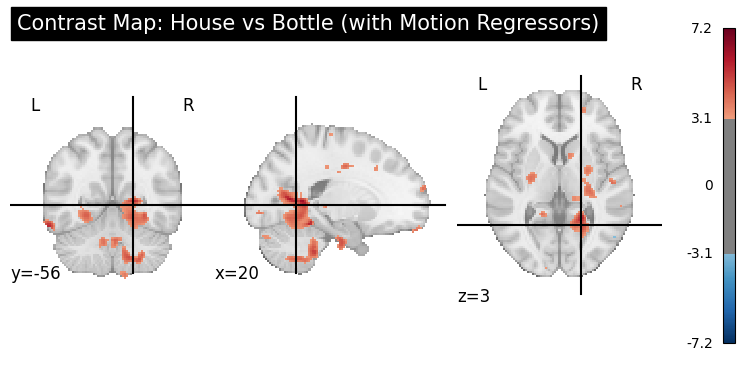

In [119]:
# Get activation map for the 'house' condition
house_contrast = fmri_glm_with_motion.compute_contrast('house')

# Get activation map for the 'bottle' condition
bottle_contrast = fmri_glm_with_motion.compute_contrast('bottle')

# Get contrast map between 'house' and 'bottle' conditions
house_vs_bottle_contrast = fmri_glm_with_motion.compute_contrast('house - bottle')

# Visualize the contrast map between 'house' and 'bottle' conditions
plotting.plot_stat_map(
    house_vs_bottle_contrast,
    threshold=3.1, # z=3.1 correspond to p = 0.001 (1-tailed), uncorrected
    cut_coords=[20, -56, 3], # to make it comparable to previous contrast map with same cut coords
    vmin=-7.2, vmax=7.2,   # to make it comparable to previous contrast map with same color scale
    title='Contrast Map: House vs Bottle (with Motion Regressors)'
)

I hope you can see that after adding motion regressors, the clusters surviving the threshold become larger. Note this is just one run, and this subject's head motion in this run is pretty small, and the effect we are looking here is a very robust one. If you have multiple runs, and head motion is worse and you are looking at some small effect, you probably would have observed the difference between "no effect" and "there is an effect".

In [120]:
# ------- Save the statistic maps -------

# Define output directory for saving the statistic maps
house_vs_bottle_contrast_path = fsl_manager.create_path(
    src=func_r1_path,
    proc="house-bottle",
    suffix="zstat",
    extension=".nii.gz"
)

# Save the contrast map to the defined path
house_vs_bottle_contrast.to_filename(house_vs_bottle_contrast_path)
print("Contrast map saved to:", house_vs_bottle_contrast_path)

Contrast map saved to: /Users/yuanfangzhao/Documents/Teaching/Neuroimaging/fMRI_colab_tutorial/data/derivatives/fsl_preproc/sub-1/func/sub-1_task-objectviewing_run-01_proc-house-bottle_zstat.nii.gz


In [121]:
# Number of runs
n = 8

for run_id in range(1, n + 1):
    print(f"Processing run {run_id}...")
    
    # Get the file path of the preprocessed functional image for subject "sub-1", run "{run_id}"
    func_r_path = fsl_manager.find_path(subject="1", run=str(run_id), proc="clean", extension=".nii.gz")[0]
    
    # Get the event timing file for subject "sub-1", run "{run_id}"
    event_r_file = layout.get(subject="1", suffix="events", extension=".tsv", run=str(run_id), return_type="file")[0]
    
    # Load the event timing file into a pandas DataFrame
    events_r = pd.read_csv(event_r_file, sep="\t")

    # get head motion parameters file for subject "sub-1", run "{run_id}"
    motion_file = fsl_manager.find_path(subject="1", run=str(run_id), proc="mc", extension=".nii.gz.par")[0]
    
    # Load the head motion parameters
    motion_params = pd.read_csv(motion_file, delim_whitespace=True, header=None)
    
    # Fit the GLM model
    fmri_glm = FirstLevelModel(
        t_r=2.5,
        hrf_model='glover',
        drift_model=None,          # Already high-pass filtered
        high_pass=None,            # No additional filtering
        smoothing_fwhm=None,       # Already smoothed
    )
    
    fmri_glm = fmri_glm.fit(func_r_path, events=events_r, confounds=motion_params)
    
    # Get contrast map between 'house' and 'bottle' conditions
    house_vs_bottle_contrast = fmri_glm.compute_contrast('house - bottle')

    # get contrast map between 'chair' and 'shoe' conditions
    chair_vs_shoe_contrast = fmri_glm.compute_contrast('chair - shoe')
    
    # Define output directory for saving the statistic maps
    house_vs_bottle_contrast_path = fsl_manager.create_path(
        src=func_r_path,
        proc="house-bottle",
        suffix="zstat",
        extension=".nii.gz"
    )
    
    # Define output directory for saving the statistic maps
    chair_vs_shoe_contrast_path = fsl_manager.create_path(
        src=func_r_path,
        proc="chair-shoe",
        suffix="zstat",
        extension=".nii.gz"
    )
    
    # Save the contrast maps to the defined paths
    house_vs_bottle_contrast.to_filename(house_vs_bottle_contrast_path)
    print(f"Contrast map for run {run_id} saved to:", house_vs_bottle_contrast_path)
    
    chair_vs_shoe_contrast.to_filename(chair_vs_shoe_contrast_path)
    print(f"Contrast map for run {run_id} saved to:", chair_vs_shoe_contrast_path)

Processing run 1...
Contrast map for run 1 saved to: /Users/yuanfangzhao/Documents/Teaching/Neuroimaging/fMRI_colab_tutorial/data/derivatives/fsl_preproc/sub-1/func/sub-1_task-objectviewing_run-01_proc-house-bottle_zstat.nii.gz
Contrast map for run 1 saved to: /Users/yuanfangzhao/Documents/Teaching/Neuroimaging/fMRI_colab_tutorial/data/derivatives/fsl_preproc/sub-1/func/sub-1_task-objectviewing_run-01_proc-chair-shoe_zstat.nii.gz
Processing run 2...
Contrast map for run 2 saved to: /Users/yuanfangzhao/Documents/Teaching/Neuroimaging/fMRI_colab_tutorial/data/derivatives/fsl_preproc/sub-1/func/sub-1_task-objectviewing_run-02_proc-house-bottle_zstat.nii.gz
Contrast map for run 2 saved to: /Users/yuanfangzhao/Documents/Teaching/Neuroimaging/fMRI_colab_tutorial/data/derivatives/fsl_preproc/sub-1/func/sub-1_task-objectviewing_run-02_proc-chair-shoe_zstat.nii.gz
Processing run 3...
Contrast map for run 3 saved to: /Users/yuanfangzhao/Documents/Teaching/Neuroimaging/fMRI_colab_tutorial/data/de